In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [94]:
#!usr/bin/env python
#encoding:utf-8
from __future__ import division
 
 
'''
__Author__:沂水寒城
功能：计算回归分析模型中常用的四大评价指标
'''
 
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
 
 
 
def calPerformance(y_true,y_pred):
    '''
    模型效果指标评估
    y_true：真实的数据值
    y_pred：回归模型预测的数据值
    explained_variance_score：解释回归模型的方差得分，其值取值范围是[0,1]，越接近于1说明自变量越能解释因变量
    的方差变化，值越小则说明效果越差。
    mean_absolute_error：平均绝对误差（Mean Absolute Error，MAE），用于评估预测结果和真实数据集的接近程度的程度
    ，其其值越小说明拟合效果越好。
    mean_squared_error：均方差（Mean squared error，MSE），该指标计算的是拟合数据和原始数据对应样本点的误差的
    平方和的均值，其值越小说明拟合效果越好。
    r2_score：判定系数，其含义是也是解释回归模型的方差得分，其值取值范围是[0,1]，越接近于1说明自变量越能解释因
    变量的方差变化，值越小则说明效果越差。
    '''
    model_metrics_name=[explained_variance_score, mean_absolute_error, mean_squared_error, r2_score]  
    tmp_list=[]  
    for one in model_metrics_name:  
        tmp_score=one(y_true,y_pred)  
        tmp_list.append(tmp_score)  
    print(['explained_variance_score','mean_absolute_error','mean_squared_error','r2_score'])
    print(tmp_list)
    return tmp_list
 


In [138]:
hs300 =  pd.read_csv('../../data/final/hs300(2013-2022).csv').set_index('trade_date').sort_index()
hs300.index = pd.to_datetime(hs300.index, format='%Y%m%d')
hs_index = hs300.copy()
hs_index['return'] = hs_index['close'].pct_change()
hs_index['return_t+1'] = hs_index['return'].shift(-1)
hs_index['return_t+1'] = hs_index['return_t+1'].fillna(0)
hs_index['return_t+1'] = hs_index['return_t+1'].apply(lambda x:round(x,4))
hs_index['return_t+1(%)'] = hs_index['return_t+1']*100
hs_index = hs_index['20130101':'20221231']
hs_index = hs_index.resample('M').mean()
hs_index.index = hs_index.index.strftime('%Y%m')
hs_index

,close,open,high,low,vol,return,return_t+1,return_t+1(%)
trade_date,,,,,,,,
201301,2584.876100,2577.967400,2603.282100,2555.729650,8.592251e+07,0.003376,0.004265,0.426500
201302,2689.592667,2688.599733,2714.804200,2662.006333,8.462652e+07,-0.000218,-0.001740,-0.174000
201303,2576.224143,2579.023714,2602.523429,2551.332571,7.041034e+07,-0.003132,-0.003095,-0.309524
201304,2477.478500,2476.676333,2499.811944,2457.821500,5.241585e+07,-0.000999,-0.000906,-0.090556
201305,2565.250682,2557.392818,2579.605773,2543.283136,6.530091e+07,0.002911,0.002805,0.280455
...,...,...,...,...,...,...,...,...
202208,4140.191704,4139.714039,4164.643009,4111.879461,1.062202e+08,-0.000917,-0.001487,-0.148696
202209,3958.925486,3968.910219,3989.980986,3939.124486,9.860253e+07,-0.003266,-0.003905,-0.390476
202210,3711.625756,3723.604675,3756.422463,3686.912800,1.069154e+08,-0.004960,-0.001344,-0.134375


In [136]:
hs_index.to_csv('../../data/final/hs300_ret_monthly(2013-2022).csv')

In [96]:
marco_data =  pd.read_csv('../../data/final/all_macro.CSV', encoding="gbk", index_col=0)
marco_data.index = pd.to_datetime(marco_data.index)
# 整体shift(-1)
marco_data = marco_data.shift(-1)
marco_data = marco_data['20130101':'20221231'].resample('M').mean()
marco_data.index = marco_data.index.strftime('%Y%m')
marco_data["return_t+1(%)"] = hs_index["return_t+1(%)"]
# # 删除202212
marco_data = marco_data[:-1]
marco_data

,银行间同业拆借加权利率:1个月:月:平均值,7天回购利率:加权平均:最近1月(B1M):月:平均值,银行间质押式回购加权利率:1个月:月:平均值,活期存款利率(月),定期存款利率:3个月(月),定期存款利率:6个月(月),定期存款利率:1年(整存整取)(月),定期存款利率:3年(整存整取)(月),人民银行对金融机构存款利率:法定准备金(月),人民银行对金融机构存款利率:超额准备金(月),...,万得全A:月:平均值,成交金额:万得全A:月:平均值,成交量:万得全A:月:平均值,静态市盈率:万得全A:月:平均值,滚动市盈率(TTM):万得全A:月:平均值,市净率:万得全A:月:平均值,Wind行业指数:工业:月:平均值,中债国债到期收益率:1个月,中债国债到期收益率:1年,return_t+1(%)
指标名称,,,,,,,,,,,,,,,,,,,,,
201301,3.827433,3.174647,3.854060,0.35,2.6,2.8,3.0,4.25,1.62,0.72,...,2355.763033,2.001366e+08,204050820.1,14.668625,14.793500,1.862261,2157.172233,1.5078,1.7000,0.426500
201302,3.482276,3.301505,3.455576,0.35,2.6,2.8,3.0,4.25,1.62,0.72,...,2301.033648,1.829666e+08,189427128.6,14.159529,14.268323,1.788571,2101.696671,1.4788,1.7331,-0.174000
201303,3.548621,3.211562,3.576019,0.35,2.6,2.8,3.0,4.25,1.62,0.72,...,2222.911206,1.418688e+08,146882130.2,13.527907,13.560423,1.688423,2021.514228,1.4520,1.7210,-0.309524
201304,3.673742,3.415759,3.766359,0.35,2.6,2.8,3.0,4.25,1.62,0.72,...,2334.900959,1.983724e+08,195529747.8,14.131587,13.745352,1.697471,2136.758468,1.4500,1.7192,-0.090556
201305,7.175700,5.566932,7.501516,0.35,2.6,2.8,3.0,4.25,1.62,0.72,...,2204.298006,1.661773e+08,172556384.6,13.454820,13.087310,1.632460,2038.107259,1.4620,1.7250,0.280455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202207,1.794648,1.563152,1.713400,0.35,1.1,1.3,1.5,2.75,1.62,0.35,...,5210.439687,1.005638e+09,776680451.5,17.980981,17.581377,1.755003,4834.572665,1.7065,2.0403,-0.300952
202208,2.001605,1.637848,1.913110,0.35,1.1,1.3,1.5,2.75,1.62,0.35,...,4940.398581,7.271462e+08,618604624.3,17.381080,17.000253,1.654413,4515.481648,1.6853,2.0416,-0.148696
202209,2.058167,1.765900,1.899694,0.35,1.1,1.3,1.5,2.75,1.62,0.35,...,4704.755006,7.928845e+08,635283912.5,16.637377,16.213729,1.577403,4379.784031,1.6906,2.0419,-0.390476


In [97]:
# 筛选出 涨跌幅:上证综合指数:月:平均值
temp  =  marco_data[["涨跌幅:上证综合指数:月:平均值", "return_t+1(%)"]]
temp

,涨跌幅:上证综合指数:月:平均值,return_t+1(%)
指标名称,,
201301,-0.047874,0.426500
201302,-0.256607,-0.174000
201303,-0.142696,-0.309524
201304,0.252207,-0.090556
201305,-0.869303,0.280455
...,...,...
202207,-0.065077,-0.300952
202208,-0.267807,-0.148696
202209,-0.269961,-0.390476


In [98]:
# 标准化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
marco_all = marco_data.values
data_all = scaler.fit_transform(marco_all)
# 存储每个特征的最值，用于inverse
mins = marco_data.min()
maxs = marco_data.max()
y_min = mins['return_t+1(%)']
y_max = maxs['return_t+1(%)']

In [99]:
print(marco_all.shape)
data = []
for index in range(len(marco_all)-10):
        data.append(marco_all[index:index+10+1])
data = np.array(data)
print(data.shape)

(119, 193)
(109, 11, 193)


# LSTM提取宏观经济过程

In [100]:
# 划分训练集测试集、seq_lenth设定
def changeData(dataset, lookback, ):
    # dataset = dataset.to_numpy()
    data = []
    for index in range(len(dataset)-lookback):
        data.append(dataset[index:index+lookback+1])
    data = np.array(data)
    test_size = int(np.round(0.2*data.shape[0]))
    train_size = data.shape[0] - test_size

    x_train = data[:train_size, :-1, :]
    y_train = data[:train_size, -1, -1]

    x_test = data[train_size:, :-1, :]
    y_test = data[train_size:, -1, -1]


    return x_train, y_train,x_test, y_test

In [101]:
x_train, y_train, x_test, y_test = changeData(marco_all, 5)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


train_dataset = TensorDataset(torch.from_numpy(x_train).to(torch.float32), torch.from_numpy(y_train).to(torch.float32))
test_dataset = TensorDataset(torch.from_numpy(x_test).to(torch.float32), torch.from_numpy(y_test).to(torch.float32))

(91, 5, 193) (91,) (23, 5, 193) (23,)


In [102]:
class LSTMFeatureExtractor(nn.Module):
    def __init__(self, input_size, hidden_size, feature_size, num_layers=1, output_size=1):
        super(LSTMFeatureExtractor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.relu_1 = nn.LeakyReLU()
        self.fc_stock = nn.Linear(hidden_size, output_size)  # 输出股票价格预测
        self.fc_features = nn.Linear(hidden_size, feature_size)  # 输出低维度经济特征


    def forward(self, x):
        out, (h0, c0) = self.lstm(x)
        out = self.relu_1(out)
        stock_prediction = self.fc_stock(out[:, -1, :])  # 预测股票价格
        features = self.fc_features(h0.view(-1, h0.size(2)))  # 提取低维度经济特征


        return stock_prediction, features
    

In [103]:
# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch [0/100], Loss: 0.1053
Epoch [1/100], Loss: 0.1403
Epoch [2/100], Loss: 0.1212
Epoch [3/100], Loss: 0.0938
Epoch [4/100], Loss: 0.1009
Epoch [5/100], Loss: 0.1099
Epoch [6/100], Loss: 0.0977
Epoch [7/100], Loss: 0.0946
Epoch [8/100], Loss: 0.0912
Epoch [9/100], Loss: 0.1028
Epoch [10/100], Loss: 0.1149
Epoch [11/100], Loss: 0.1144
Epoch [12/100], Loss: 0.0758
Epoch [13/100], Loss: 0.1329


c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [14/100], Loss: 0.0728
Epoch [15/100], Loss: 0.1035
Epoch [16/100], Loss: 0.0502
Epoch [17/100], Loss: 0.0963
Epoch [18/100], Loss: 0.1362
Epoch [19/100], Loss: 0.1880
Epoch [20/100], Loss: 0.1167
Epoch [21/100], Loss: 0.1659
Epoch [22/100], Loss: 0.1514
Epoch [23/100], Loss: 0.0569
Epoch [24/100], Loss: 0.1292
Epoch [25/100], Loss: 0.1167
Epoch [26/100], Loss: 0.1615
Epoch [27/100], Loss: 0.1263
Epoch [28/100], Loss: 0.1319
Epoch [29/100], Loss: 0.0921
Epoch [30/100], Loss: 0.1285
Epoch [31/100], Loss: 0.1586
Epoch [32/100], Loss: 0.1106
Epoch [33/100], Loss: 0.2196
Epoch [34/100], Loss: 0.1117
Epoch [35/100], Loss: 0.1360
Epoch [36/100], Loss: 0.1030
Epoch [37/100], Loss: 0.1097
Epoch [38/100], Loss: 0.0916
Epoch [39/100], Loss: 0.1138
Epoch [40/100], Loss: 0.0835
Epoch [41/100], Loss: 0.1134
Epoch [42/100], Loss: 0.0712
Epoch [43/100], Loss: 0.1456
Epoch [44/100], Loss: 0.0928
Epoch [45/100], Loss: 0.1354
Epoch [46/100], Loss: 0.1256
Epoch [47/100], Loss: 0.1640
Epoch [48/100]

Epoch [49/100], Loss: 0.1382
Epoch [50/100], Loss: 0.1639
Epoch [51/100], Loss: 0.0845
Epoch [52/100], Loss: 0.0739
Epoch [53/100], Loss: 0.1738
Epoch [54/100], Loss: 0.1503
Epoch [55/100], Loss: 0.1842
Epoch [56/100], Loss: 0.1537
Epoch [57/100], Loss: 0.1809
Epoch [58/100], Loss: 0.1543
Epoch [59/100], Loss: 0.1069
Epoch [60/100], Loss: 0.0589
Epoch [61/100], Loss: 0.1234
Epoch [62/100], Loss: 0.1383
Epoch [63/100], Loss: 0.0585
Epoch [64/100], Loss: 0.0762
Epoch [65/100], Loss: 0.1033
Epoch [66/100], Loss: 0.0939
Epoch [67/100], Loss: 0.1460
Epoch [68/100], Loss: 0.1241
Epoch [69/100], Loss: 0.0912
Epoch [70/100], Loss: 0.1397
Epoch [71/100], Loss: 0.1668
Epoch [72/100], Loss: 0.0532
Epoch [73/100], Loss: 0.0740
Epoch [74/100], Loss: 0.0857
Epoch [75/100], Loss: 0.0962
Epoch [76/100], Loss: 0.0626
Epoch [77/100], Loss: 0.1890
Epoch [78/100], Loss: 0.0935
Epoch [79/100], Loss: 0.1080
Epoch [80/100], Loss: 0.0510
Epoch [81/100], Loss: 0.1535
Epoch [82/100], Loss: 0.1169
Epoch [83/100]

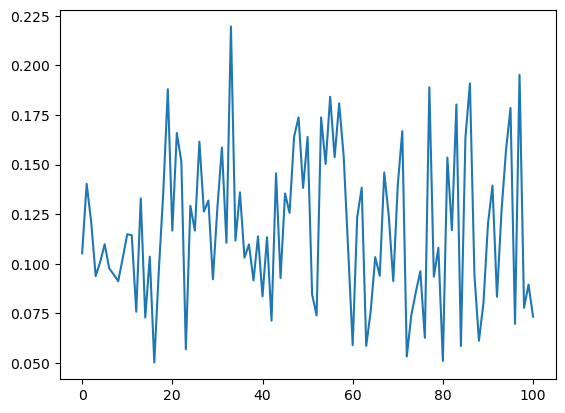

In [104]:
# 初始化模型、损失函数和优化器
feature_extractor = LSTMFeatureExtractor(input_size = marco_all.shape[1], hidden_size = 16, feature_size = 5)
criterion = nn.MSELoss()
optimizer = optim.Adam(feature_extractor.parameters(), lr = 0.0005)

# 训练模型
feature_extractor.train()
epochs = 100
losses = []
for epoch in range(epochs+1):
    for i, (inputs, labels) in enumerate(train_loader):
        # print(inputs.shape)
        # print(labels.shape)
        y_predict, features = feature_extractor(inputs)  # 提取低维特征
        optimizer.zero_grad()
        # print(features.shape)
        # print(labels.shape)
        loss = criterion(y_predict, labels)   # 计算损失
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 1 == 0:
        losses.append(loss.item())
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, epochs, loss.item()))

# 画出损失函数曲线
plt.plot(losses)


(23, 1) (23,) (23, 5)


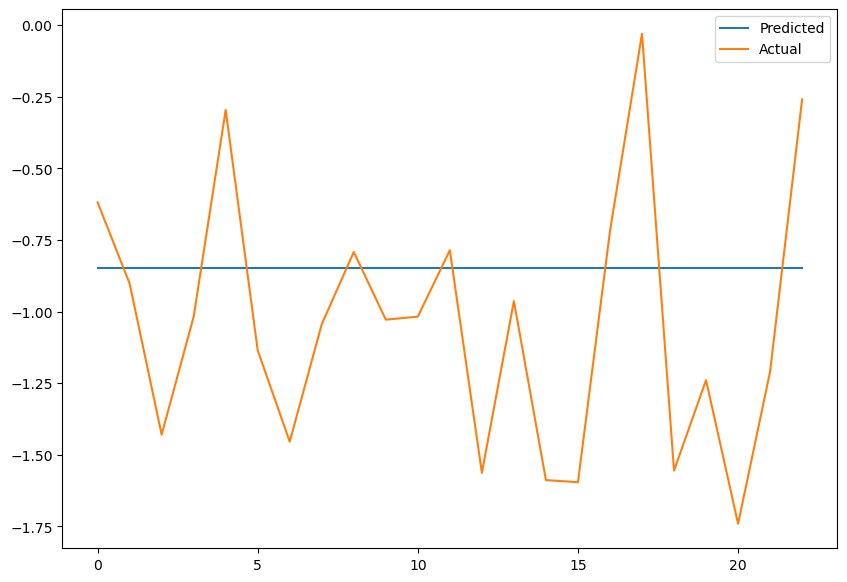

In [105]:
# 测试模型
feature_extractor.eval()
y_predicts = []
y_labels = []
features_list = []
for inputs, labels in test_loader:
    y_predict, features = feature_extractor(inputs)
    y_predicts.append(y_predict.detach().numpy())
    y_labels.append(labels.detach().numpy())
    features_list.append(features.detach().numpy())
y_predicts = np.concatenate(y_predicts)
y_labels = np.concatenate(y_labels)
features_list = np.concatenate(features_list)
print(y_predicts.shape, y_labels.shape, features_list.shape)

# 反标准化
y_predicts = y_predicts*(y_max-y_min)+y_min
y_labels = y_labels*(y_max-y_min)+y_min
# 画出预测结果
plt.figure(figsize=(10, 7))
plt.plot(y_predicts, label='Predicted')
plt.plot(y_labels, label='Actual')
plt.legend()
plt.show()


# Lasso回归，提取宏观经济特征

In [106]:
marco_data.iloc[:, :-1].values.shape

(119, 192)

In [107]:
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler


# 假设你有一个包含宏观经济特征的数据集X，以及目标变量y
# 请确保数据已经经过标准化（均值为0，方差为1）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(marco_data.iloc[:, :-1].values)
y_scaled = scaler.fit_transform(marco_data.iloc[:, -1].values.reshape(-1, 1))

# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(95, 192) (24, 192) (95, 1) (24, 1)


In [108]:
lasso = Lasso(alpha=0.3)

# 拟合Lasso回归模型
lasso.fit(X_train, y_train)

# 预测测试集数据
y_pred = lasso.predict(X_test)

# 反标准化
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten() 
# 计算评价指标
mse = mean_squared_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
print('Mean squared error = ', round(mse, 2))
print('Explained variance score = ', round(evs, 2))


Mean squared error =  0.11
Explained variance score =  0.0


alpha =  0.01 

alpha =  0.012 

alpha =  0.014 

alpha =  0.016 

alpha =  0.018000000000000002 

alpha =  0.02 

alpha =  0.022 

alpha =  0.024 

alpha =  0.026000000000000002 

alpha =  0.028000000000000004 

alpha =  0.03 

alpha =  0.032 

alpha =  0.034 

alpha =  0.036000000000000004 

alpha =  0.038 

alpha =  0.04 

alpha =  0.042 

alpha =  0.044000000000000004 

alpha =  0.046000000000000006 

alpha =  0.048 

alpha =  0.05 

alpha =  0.052000000000000005 

alpha =  0.054 

alpha =  0.056 

alpha =  0.058 

alpha =  0.060000000000000005 

alpha =  0.062000000000000006 

alpha =  0.064 

alpha =  0.066 

alpha =  0.068 

alpha =  0.06999999999999999 

alpha =  0.072 

alpha =  0.074 

alpha =  0.076 

alpha =  0.078 

alpha =  0.08 

alpha =  0.082 

alpha =  0.08399999999999999 

alpha =  0.086 

alpha =  0.088 

alpha =  0.09 

alpha =  0.092 

alpha =  0.094 

alpha =  0.096 

alpha =  0.09799999999999999 

alpha =  0.09999999999999999 

alpha =  0.102 

alpha =  0.104 



c:\Users\16963\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.370e-02, tolerance: 9.347e-03
  model = cd_fast.enet_coordinate_descent(


alpha =  0.11599999999999999 

alpha =  0.118 

alpha =  0.12 

alpha =  0.122 

alpha =  0.124 

alpha =  0.126 

alpha =  0.128 

alpha =  0.13 

alpha =  0.132 

alpha =  0.134 

alpha =  0.136 

alpha =  0.138 

alpha =  0.14 

alpha =  0.14200000000000002 

alpha =  0.14400000000000002 

alpha =  0.14600000000000002 

alpha =  0.14800000000000002 



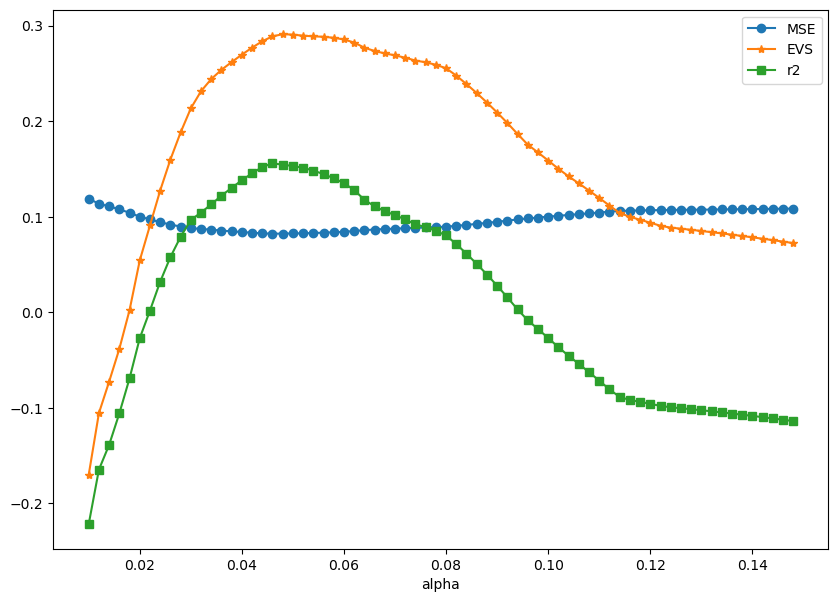

In [109]:
mse_lst = []
evs_lst = []
r2_lst = []
# alpha从0.001到0.1，步长为0.001
for a in np.arange(0.01, 0.15, 0.002):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
    print("alpha = ", a, "\n")
    # 初始化Lasso回归模型
    lasso = Lasso(alpha=a)

    # 拟合Lasso回归模型
    lasso.fit(X_train, y_train)

    # 预测测试集数据
    y_pred = lasso.predict(X_test)

    # 反标准化
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten() 
   # 计算评价指标
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    r2_square = r2_score(y_test, y_pred)
    mse_lst.append(mse)
    evs_lst.append(evs)
    r2_lst.append(r2_square)



# 画图
plt.figure(figsize=(10, 7))
plt.plot(np.arange(0.01, 0.15, 0.002), mse_lst, label='MSE', marker='o')
plt.plot(np.arange(0.01, 0.15, 0.002), evs_lst, label='EVS', marker='*')
plt.plot(np.arange(0.01, 0.15, 0.002), r2_lst, label='r2', marker='s')
plt.xlabel('alpha')
plt.legend()

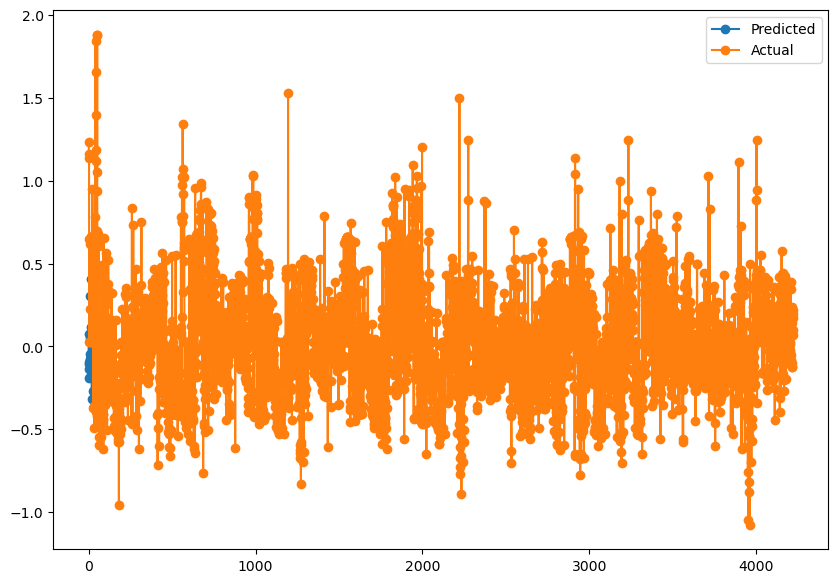

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
# 初始化Lasso回归模型
lasso = Lasso(alpha=0.045)

# 拟合Lasso回归模型
lasso.fit(X_train, y_train)

# 预测测试集数据
y_pred = lasso.predict(X_train[2:27, :])

# 反标准化
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(X_test[2:27, :].reshape(-1, 1)).flatten() 
# # 计算评价指标
# mse = mean_squared_error(y_test, y_pred)
# evs = explained_variance_score(y_test, y_pred)
# r2_square = r2_score(y_test, y_pred)
# # 画出预测结果
plt.figure(figsize=(10, 7))
plt.plot(y_pred, label='Predicted',marker='o',)
plt.plot(y_test, label='Actual',marker='o',)
plt.legend()
plt.show()

In [111]:
# 查看Lasso回归模型的特征权重
lasso_coefficients = lasso.coef_
# 打印特征权重，绝对值较大的表示影响较大的特征
print("特征权重 (系数):")
coeff = {}
for feature, coefficient in zip(marco_data.columns[:-1], lasso_coefficients):
    coeff[feature] = coefficient
    print(f"{feature}: {coefficient}")
    

特征权重 (系数):
银行间同业拆借加权利率:1个月:月:平均值: 0.0
7天回购利率:加权平均:最近1月(B1M):月:平均值: -0.0
银行间质押式回购加权利率:1个月:月:平均值: 0.0
活期存款利率(月): 0.0
定期存款利率:3个月(月): 0.0
定期存款利率:6个月(月): 0.0
定期存款利率:1年(整存整取)(月): 0.0
定期存款利率:3年(整存整取)(月): 0.0
人民银行对金融机构存款利率:法定准备金(月): 0.0
人民银行对金融机构存款利率:超额准备金(月): 0.0
短期贷款利率:6个月(含)(月): 0.0035682883632793534
短期贷款利率:6个月至1年(含)(月): 0.0
中长期贷款利率:1至3年(含)(月): 0.0
中长期贷款利率:5年以上(月): 0.0
中长期贷款利率:3至5年(含)(月): 0.0
个人住房公积金贷款利率:5年以下(含5年)(月): 0.0
个人住房公积金贷款利率:5年以上(月): 0.0
人民银行对金融机构贷款利率:20天以内(月): 0.0
人民银行对金融机构贷款利率:3个月以内(月): 0.0
人民银行对金融机构贷款利率:6个月以内(月): 0.0
人民银行对金融机构贷款利率:1年(月): 0.0
人民银行对金融机构贷款利率:再贴现利率(月): 0.0
中债国债到期收益率:1个月:月:平均值: 0.12671293103854736
中债国债到期收益率:1年:月:平均值: 0.0
中债国债到期收益率:5年:月:平均值: 0.0
中债国债到期收益率:10年:月:平均值: 0.0
中债国债到期收益率:3个月:月:平均值: 0.0
中债国债到期收益率:6个月:月:平均值: 0.0
平均汇率:美元兑人民币: -0.0
平均汇率:欧元兑人民币: -0.0
平均汇率:港元兑人民币: -0.0
平均汇率:100日元兑人民币: -0.0
人民币:实际有效汇率指数: 0.0
人民币:名义有效汇率指数: 0.0
中间价:英镑兑人民币:月:平均值: -0.0
中间价:澳元兑人民币:月:平均值: 0.0
中间价:加元兑人民币:月:平均值: 0.0
中间价:新西兰元兑人民币:月:平均值: 0.3246822924984035
中间价:新加坡元兑人民币:月:平均值: -0.0
人民币存款准备金率:中

In [112]:
# 按照值从大到小对coeffj进行排序
coeff = dict(sorted(coeff.items(), key=lambda item: abs(item[1]), reverse=True))
coeff

{'中间价:新西兰元兑人民币:月:平均值': 0.3246822924984035,
 '上证综合指数:月:平均值': 0.27832573851433096,
 'M0:同比': -0.2691425735554497,
 '出口价格指数(BEC):未列名的消费品': 0.15769307855775852,
 '换手率:上证综合指数:月:平均值': 0.12940953114119452,
 '中债国债到期收益率:1个月:月:平均值': 0.12671293103854736,
 '银行间同业拆借:成交金额:30天:当月值': 0.1145046483336259,
 '金融机构:本外币贷款余额:初值:同比': -0.11214536115802003,
 '进口价格指数(BEC):运输设备及其零件和附件': 0.10945445781833155,
 '社会融资规模:当月值': 0.10030733320289702,
 'GDP:现价:累计同比:月:均值': -0.09541000914049082,
 'CPI:居住:当月同比': -0.07319022067931844,
 'CGPI:煤油电:当月同比': -0.06068699326547711,
 '货币当局:其他负债': -0.05714426014052913,
 '社会融资规模:累计值': 0.04852464471655794,
 '货币当局:国外负债': 0.04408874997437888,
 '出口价格指数(BEC):食品和饮料': 0.034559700083893405,
 'RPI:当月同比': -0.027254159876515856,
 '上证所:A股平均市盈率': 0.022732313754636295,
 '涨跌幅:上证综合指数:月:平均值': 0.02255808501892987,
 '货币当局:储备货币:其他存款性公司存款': 0.015067105751985246,
 '进口价格指数(BEC):未列名的消费品:耐用品': 0.013729691751534004,
 '现金净投放:当月值': 0.013440163780244773,
 '进口价格指数(BEC):未列名的消费品:非耐用品': -0.01075723194886828,
 '短期贷款利率:6

# 随机森林特征选择

['explained_variance_score', 'mean_absolute_error', 'mean_squared_error', 'r2_score']
[0.20384398717233898, 0.2233721854393267, 0.09160796949662407, 0.05981203393341583]


C:\Users\16963\AppData\Local\Temp\ipykernel_41156\3428179610.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regressor.fit(X_train, y_train)


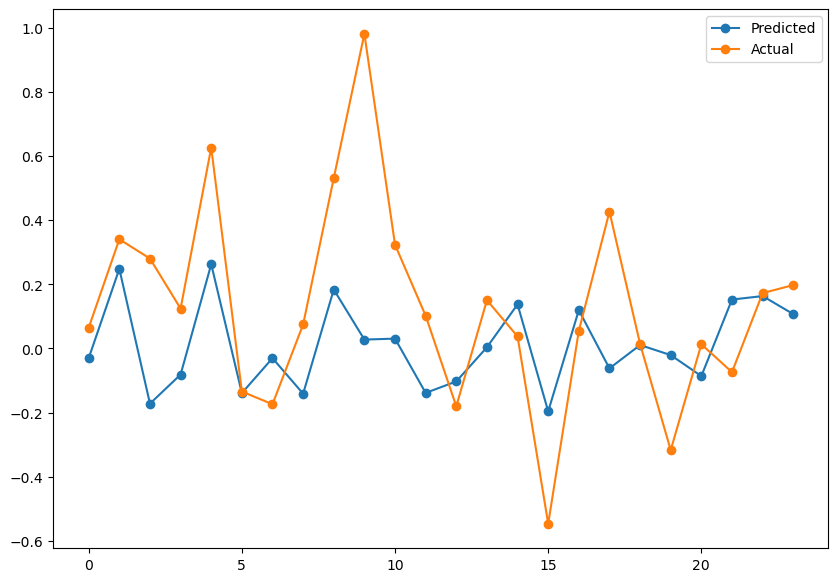

In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 假设你有一个包含宏观经济特征的数据集X，以及目标变量y
# 请确保数据已经经过标准化（均值为0，方差为1）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(marco_data.iloc[:, :-1].values)
y_scaled = scaler.fit_transform(marco_data.iloc[:, -1].values.reshape(-1, 1))
# print(X_scaled.shape, y_scaled.shape)
# 分割数据为训练集和测试集


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
# 创建随机森林回归模型
rf_regressor = RandomForestRegressor(n_estimators = 20, random_state=42)

# 拟合数据
rf_regressor.fit(X_train, y_train)

# 预测测试集数据
y_pred = rf_regressor.predict(X_test)

# 反标准化
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 计算评价指标
calPerformance(y_test, y_pred)

# 绘制预测结果
plt.figure(figsize=(10, 7))
plt.plot(y_pred, label='Predicted', marker='o')
plt.plot(y_test, label='Actual', marker='o')
plt.legend()
plt.show()

In [114]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]
feat_labels = marco_data.columns[:-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) 换手率:上证综合指数:月:平均值               0.076032
 2) 银行间同业拆借:成交金额:30天:当月值           0.062951
 3) CPI:教育文化和娱乐:当月同比               0.051310
 4) 中间价:新西兰元兑人民币:月:平均值             0.045952
 5) 中间价:加元兑人民币:月:平均值               0.028920
 6) 出口价格指数(BEC):未列名的工业供应品          0.025293
 7) 出口价格指数(BEC):未列名的消费品            0.025000
 8) 金融机构:各项存款余额:同比                 0.021301
 9) 中债国债到期收益率:1个月:月:平均值            0.020418
10) 金融机构:本外币贷款余额:初值:同比             0.020280
11) 出口价格指数(BEC):燃料和润滑油             0.017911
12) 社会融资规模:当月值                     0.017586
13) CPI:非食品:当月同比                   0.016848
14) 出口价格指数(BEC):食品和饮料              0.016823
15) M1:同比                          0.015946
16) CPI:生活用品及服务:当月同比               0.015873
17) PPIRM:农副产品类:当月同比               0.015681
18) 平均汇率:欧元兑人民币                    0.015071
19) PPI:生活资料:一般日用品类:当月同比           0.014834
20) 中间价:澳元兑人民币:月:平均值               0.013355
21) 中间价:英镑兑人民币:月:平均值               0.012018
22) PPIRM:黑色金属材料类:当月同比             0.011683
23) PPIRM:木材及纸浆类:当月同比           

In [115]:
threshold = 0.1
x_selected = X_train[:, importances > threshold]
x_selected.shape

(95, 0)

# LassoNet特征选择

In [116]:
! pip install lassonet

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from lassonet import LassoNetRegressor

In [118]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(marco_data.iloc[:, :-1].values)
y_scaled = scaler.fit_transform(marco_data.iloc[:, -1].values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
# 示例特征(指标)名字
feature_names = [f'fea{i}' for i in range(1,X_train.shape[1] + 1)]
print(feature_names)

['fea1', 'fea2', 'fea3', 'fea4', 'fea5', 'fea6', 'fea7', 'fea8', 'fea9', 'fea10', 'fea11', 'fea12', 'fea13', 'fea14', 'fea15', 'fea16', 'fea17', 'fea18', 'fea19', 'fea20', 'fea21', 'fea22', 'fea23', 'fea24', 'fea25', 'fea26', 'fea27', 'fea28', 'fea29', 'fea30', 'fea31', 'fea32', 'fea33', 'fea34', 'fea35', 'fea36', 'fea37', 'fea38', 'fea39', 'fea40', 'fea41', 'fea42', 'fea43', 'fea44', 'fea45', 'fea46', 'fea47', 'fea48', 'fea49', 'fea50', 'fea51', 'fea52', 'fea53', 'fea54', 'fea55', 'fea56', 'fea57', 'fea58', 'fea59', 'fea60', 'fea61', 'fea62', 'fea63', 'fea64', 'fea65', 'fea66', 'fea67', 'fea68', 'fea69', 'fea70', 'fea71', 'fea72', 'fea73', 'fea74', 'fea75', 'fea76', 'fea77', 'fea78', 'fea79', 'fea80', 'fea81', 'fea82', 'fea83', 'fea84', 'fea85', 'fea86', 'fea87', 'fea88', 'fea89', 'fea90', 'fea91', 'fea92', 'fea93', 'fea94', 'fea95', 'fea96', 'fea97', 'fea98', 'fea99', 'fea100', 'fea101', 'fea102', 'fea103', 'fea104', 'fea105', 'fea106', 'fea107', 'fea108', 'fea109', 'fea110', 'fea111

In [119]:
n_features = X_scaled.shape[1]

In [128]:
# 创建LassoNet回归模型
model = LassoNetRegressor(
    hidden_dims=(16,),
    verbose=True,
    patience=(50, 10),
)

path = model.path(X_train, y_train)

n_selected = []
mse = []
lambda_ = []

for save in path:
    model.load(save.state_dict)
    y_pred = model.predict(X_test)
    n_selected.append(save.selected.sum().cpu().numpy())
    mse.append(mean_squared_error(y_test, y_pred))
    lambda_.append(save.lambda_)


epoch: 0
loss: 1.3612617254257202
epoch: 1
loss: 1.2420213222503662
epoch: 2
loss: 1.1750304698944092
epoch: 3
loss: 1.1200059652328491
epoch: 4
loss: 1.0674012899398804
epoch: 5
loss: 1.0210455656051636
epoch: 6
loss: 0.9844334125518799
epoch: 7
loss: 0.957056999206543
epoch: 8
loss: 0.9347308874130249
epoch: 9
loss: 0.9136716723442078
epoch: 10
loss: 0.893377959728241
epoch: 11
loss: 0.8737434148788452
epoch: 12
loss: 0.8564655184745789
epoch: 13
loss: 0.8411150574684143
epoch: 14
loss: 0.8262616395950317
epoch: 15
loss: 0.810564398765564
epoch: 16
loss: 0.7955781817436218
epoch: 17
loss: 0.7822638154029846
epoch: 18
loss: 0.7698276042938232
epoch: 19
loss: 0.7572447657585144
epoch: 20
loss: 0.7440059185028076
epoch: 21
loss: 0.7312217950820923
epoch: 22
loss: 0.7184764742851257
epoch: 23
loss: 0.7063513994216919
epoch: 24
loss: 0.6953045129776001
epoch: 25
loss: 0.6843778491020203
epoch: 26
loss: 0.673537015914917
epoch: 27
loss: 0.6626444458961487
epoch: 28
loss: 0.6521939635276794

Text(0, 0.5, 'number of selected features')

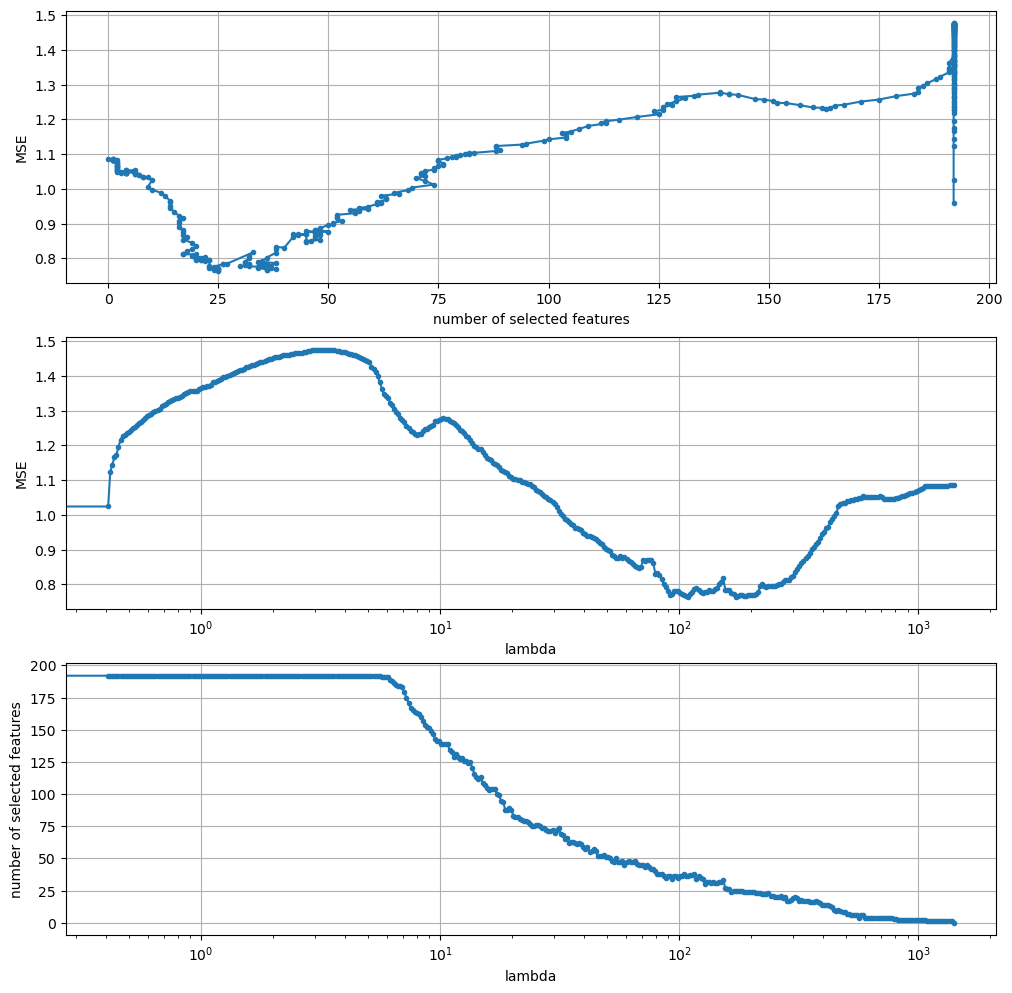

In [129]:
fig = plt.figure(figsize=(12, 12))
plt.subplot(311)
plt.grid(True)
plt.plot(n_selected, mse, ".-")
plt.xlabel("number of selected features")
plt.ylabel("MSE")

plt.subplot(312)
plt.grid(True)
plt.plot(lambda_, mse, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("MSE")

plt.subplot(313)
plt.grid(True)
plt.plot(lambda_, n_selected, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("number of selected features")


Text(0, 0.5, 'Feature order')

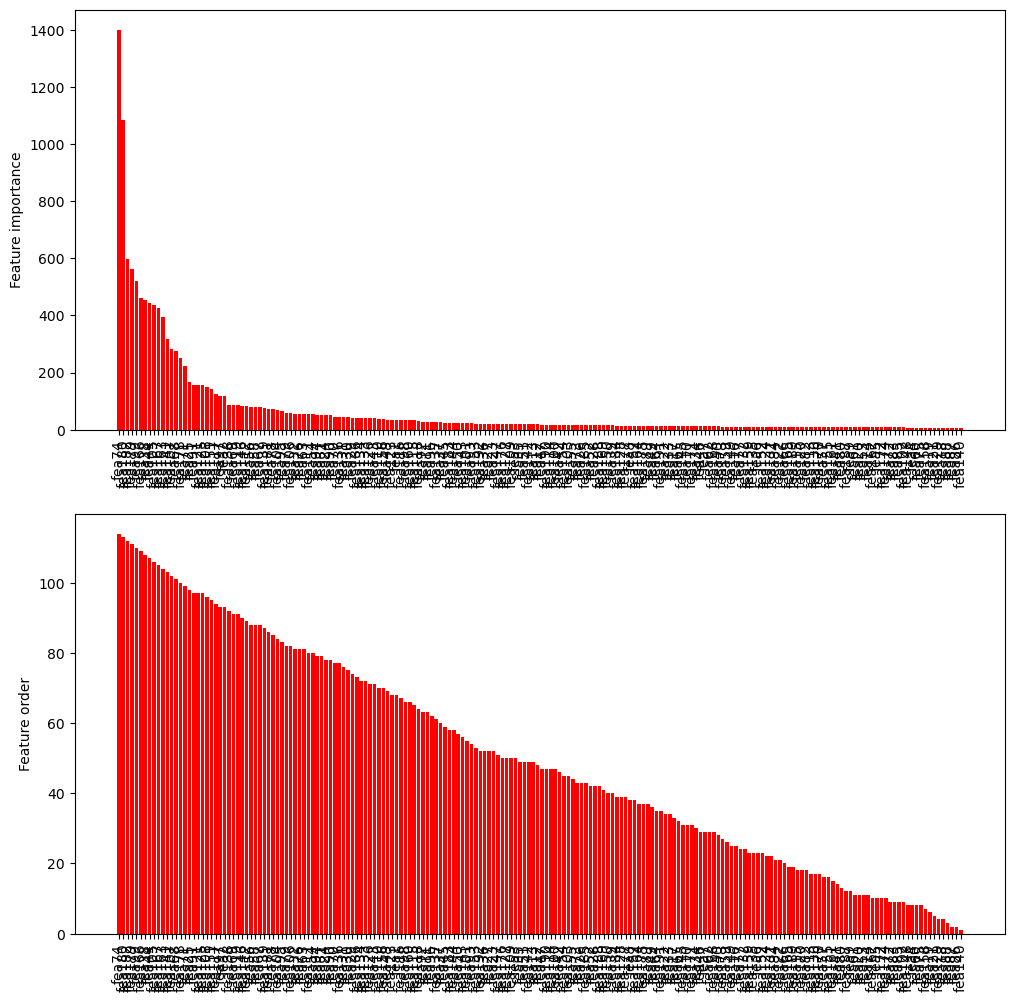

In [130]:
n_features = X_scaled.shape[1]
importances = model.feature_importances_.numpy()
order = np.argsort(importances)[::-1]
importances = importances[order]
ordered_feature_names = [feature_names[i] for i in order]



plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.bar(
    np.arange(n_features),
    importances,
    color='r',
)

plt.xticks(np.arange(n_features), ordered_feature_names, rotation=90)

plt.ylabel("Feature importance")

_, order = np.unique(importances, return_inverse=True)

plt.subplot(212)
plt.bar(
    np.arange(n_features),
    order + 1,
    color='r',
)
plt.xticks(np.arange(n_features), ordered_feature_names, rotation=90)

plt.ylabel("Feature order")

Text(0.5, 1.0, 'Top 50 feature importances')

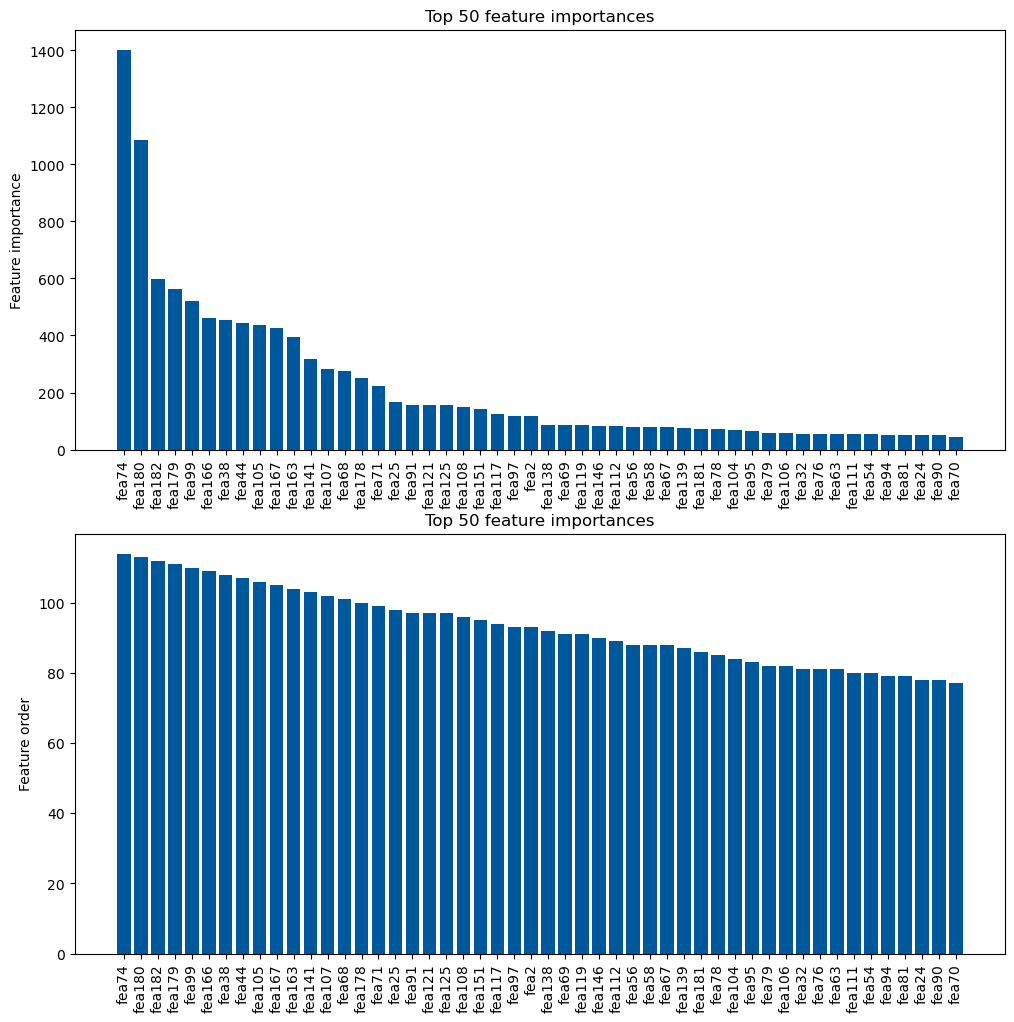

In [131]:
n_features = X_scaled.shape[1]
importances = model.feature_importances_.numpy()
order = np.argsort(importances)[::-1]
importances = importances[order]
ordered_feature_names = [feature_names[i] for i in order]

# 只选择排名前50的数据
top_n = 50
importances_top_n = importances[:top_n]
ordered_feature_names_top_n = ordered_feature_names[:top_n]

plt.figure(figsize=(12, 12))

plt.subplot(211)
plt.bar(
    np.arange(top_n),
    importances_top_n,
    color='#00589c',
)
plt.xticks(np.arange(top_n), ordered_feature_names_top_n, rotation=90)
plt.ylabel("Feature importance")
plt.title("Top 50 feature importances")

_, order = np.unique(importances, return_inverse=True)

plt.subplot(212)
plt.bar(
    np.arange(top_n),
    order[:top_n] + 1,
    color='#00589c',
)
plt.xticks(np.arange(top_n), ordered_feature_names_top_n, rotation=90)
plt.ylabel("Feature order")
plt.title("Top 50 feature importances")
